**Dating app**

You work as an analyst in an online dating app. The mechanics of the app are as follows: users see each other's profiles in the app and can like or dislike each other. If users like each other, it is called a match, and the users have the opportunity to get to know each other.

The app team developed a new algorithm for finding the most suitable profiles. An A/B test was conducted to check the algorithm. All users were divided into two groups. Users in group 0 used the app with the old algorithm. All users in group 1 used the app with the new algorithm for finding profiles.

Your task is to assess whether the new algorithm has improved the quality of the service. To do this, you need to select the metrics that is relevant to the quality of the service and statistically compare this metrics between the two groups.

The data contains logs of user interactions with each other. For each pair of users, it is indicated which AB test group they are from and whether they had a match.

The result of your work is an analytical conclusion with an answer to the question of whether it is worth turning on the new profile search system for all users.

NB! Do not use interactive graphs in the final file - they only make sense in dynamic reports like a web page.

In [1]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import bootstrap
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('dating_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [4]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

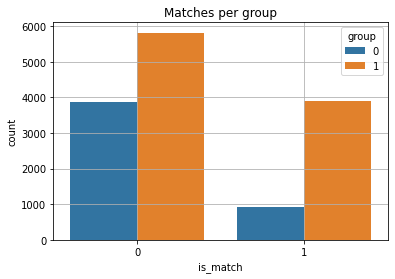

In [8]:
#Let's have a look at the graph
sns.countplot(data=df, x='is_match', hue='group')
plt.title("Matches per group")
plt.grid(True) 
#It seems that the raw data atr not informative

We see that the data represents pairs of users. Let's calculate the ratio of matches to views. To do this, we group by user 1 (we assume that to calculate the metric, we can start from user 1: if user 1 and user 2 liked each other, the field will be 1, if not - 0). Let's sum up the numbers in the is_match variable and the is_match sum, which will display the matches

In [9]:
df_rate = df.groupby(['user_id_1', 'group'], as_index = False).agg(total_views = ('is_match', 'count'), matches = ('is_match', 'sum'))

In [10]:
df_rate['match_rate'] = df_rate.matches / df_rate.total_views
df_rate

,user_id_1,group,total_views,matches,match_rate
0,1,1,24,11,0.458333
1,2,1,16,7,0.437500
2,3,1,16,5,0.312500
3,4,0,9,2,0.222222
4,5,1,22,13,0.590909
...,...,...,...,...,...
995,996,0,8,1,0.125000
996,997,0,12,1,0.083333
997,998,1,18,10,0.555556
998,999,0,7,2,0.285714


Now we have a numerical value and can compare it between the groups. First, let's check the distribution and look at the descriptives

In [11]:
pg.normality(data=df_rate, dv="match_rate", group="group", method="normaltest")

,W,pval,normal
1,0.273892,0.872017,True
0,24.051422,0.000006,False


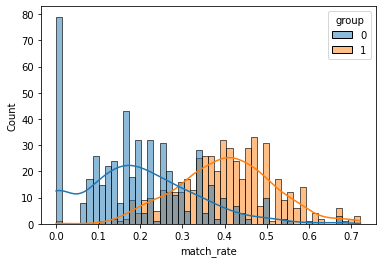

In [12]:
sns.histplot(data = df_rate, x ="match_rate", hue = 'group', bins = 50, kde=True)

We see that in the control group the data don't follow the normal distribution , since there are many values equal to 0. Let's look at these observations in more detail.

In [11]:
df_rate.query("group == 1 & match_rate == 0")

,user_id_1,group,total_views,matches,match_rate
538,539,1,16,0,0.0


In [12]:
df_rate.query("group == 0 & match_rate == 0")

,user_id_1,group,total_views,matches,match_rate
13,14,0,8,0,0.0
18,19,0,7,0,0.0
19,20,0,7,0,0.0
29,30,0,2,0,0.0
35,36,0,5,0,0.0
...,...,...,...,...,...
920,921,0,3,0,0.0
943,944,0,13,0,0.0
949,950,0,11,0,0.0
964,965,0,5,0,0.0


In [13]:
df.query("user_id_1 == 14")

,user_id_1,user_id_2,group,is_match
1670,14,632,0,0
3195,14,511,0,0
3952,14,761,0,0
4442,14,446,0,0
5703,14,223,0,0
9312,14,246,0,0
11005,14,378,0,0
11826,14,875,0,0


Indeed, in the control group there are 79 observations with 0 matches, in the reference group only 1. It seems that if we remove them as outliers, this will distort the results, since the lack of matches in a large number of participants from the control group may be due to incorrect algorythm of the recommendations (and we are testing the new algorythm)

In [14]:
#Descriptives
df_rate.groupby('group', as_index = False).match_rate.describe()

group  0      0.000000
       1      1.000000
count  0    501.000000
       1    499.000000
mean   0      0.194099
       1      0.402345
std    0      0.134302
       1      0.114106
min    0      0.000000
       1      0.000000
25%    0      0.100000
       1      0.333333
50%    0      0.181818
       1      0.400000
75%    0      0.272727
       1      0.476190
max    0      0.666667
       1      0.722222
dtype: float64

In [15]:
#Let's calculate kurtosis and skewness
stats.kurtosis(df_rate.query("group == 0").match_rate, bias=False)

0.2985076777055582

In [16]:
stats.skew(df_rate.query("group == 0").match_rate, bias=False)

0.5432052323221455

In the control group the distribution differs from normality due to a large number of zero values. At the same time, the asymmetry and kurtosis are in the range from -1 to 1, with an acceptable range of -2 to 2 ((George & Mallery, 2010), https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/Simon ). In addition, the mean and median are approximately equal. However, the SD for a normal distribution should be less than half the mean (Mishra et al., 2019). In our case, M = 0.19, SD = 0.13. Therefore, we will not take risks and use bootstrapping to compare medians

In [24]:
control = df_rate.query("group == 0").match_rate.values
test = df_rate.query("group == 1").match_rate.values

In [33]:
bootstrap((control, ), np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.16666666666666666, high=0.2), standard_error=0.010987509573202813)

In [34]:
bootstrap((test, ), np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.4, high=0.4117647058823529), standard_error=0.005570516468382163)

The confidence intervals do not overlap, which means that the medians are different.

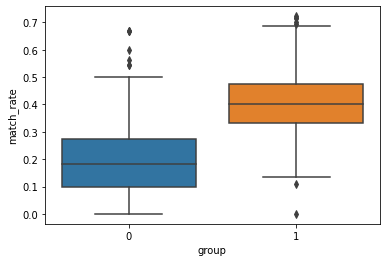

In [35]:
sns.boxplot(x='group', y='match_rate', data=df_rate)


Thus, the implementation of the new recommendation system led to a significant more than twofold increase in the match rate (120%), which suggests that this new system could be suggested to all users.